In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
%autosave 1
%matplotlib inline

Autosaving every 1 seconds


In [3]:
train = pd.read_csv('train.tsv', delimiter='\t')

In [4]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


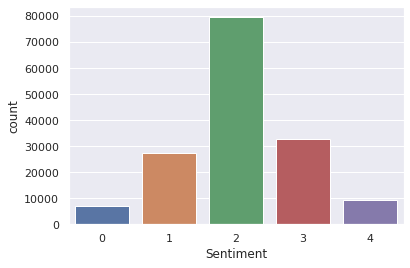

In [5]:
import seaborn as sns

sns.set()
sns.countplot(x='Sentiment',data=train)


In [6]:
#drop unecessary columns
train.drop(['PhraseId','SentenceId'],inplace = True,axis='columns')

In [7]:
from keras.preprocessing.text import text_to_word_sequence

In [8]:
#convert sentences to tokenized words
for i in range(len(train['Phrase'])):
    train['Phrase'][i] = text_to_word_sequence(train['Phrase'][i])

In [9]:
train['Phrase']

0         [a, series, of, escapades, demonstrating, the,...
1         [a, series, of, escapades, demonstrating, the,...
2                                               [a, series]
3                                                       [a]
4                                                  [series]
                                ...                        
156055                                         [hearst, 's]
156056                        [forced, avuncular, chortles]
156057                                [avuncular, chortles]
156058                                          [avuncular]
156059                                           [chortles]
Name: Phrase, Length: 156060, dtype: object

In [10]:
from keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train['Phrase'])

In [12]:
train['Phrase'] = tokenizer.texts_to_sequences(train['Phrase'])

In [13]:
train['Phrase']

0         [2, 323, 3, 1, 9, 52, 8, 46, 13, 1, 2976, 8, 1...
1                 [2, 323, 3, 1, 9, 52, 8, 46, 13, 1, 2976]
2                                                  [2, 323]
3                                                       [2]
4                                                     [323]
                                ...                        
156055                                            [4508, 6]
156056                                               [1027]
156057                                                   []
156058                                                   []
156059                                                   []
Name: Phrase, Length: 156060, dtype: object

In [14]:
from keras.preprocessing.sequence import pad_sequences
max_len = 100
train_copy = train['Phrase']
train_copy = pad_sequences(train_copy, maxlen = max_len)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

15289

In [16]:
test = pd.read_csv('test.tsv', delimiter='\t')

In [17]:
submission = pd.DataFrame()
submission['PhraseId'] = test['PhraseId']

In [18]:
test.drop(columns = ['PhraseId', 'SentenceId'], inplace = True)

In [19]:
for i in range(len(test['Phrase'])):
    test['Phrase'][i] = text_to_word_sequence(test['Phrase'][i])

In [20]:
test['Phrase'] = tokenizer.texts_to_sequences(test['Phrase'])

In [21]:
test_copy = pad_sequences(test['Phrase'], maxlen=max_len)

In [22]:
test_copy

array([[   0,    0,    0, ...,  614, 1024,  392],
       [   0,    0,    0, ...,  614, 1024,  392],
       [   0,    0,    0, ...,    0,    0,   16],
       ...,
       [   0,    0,    0, ...,    0,    2,  126],
       [   0,    0,    0, ...,    0,    2,  126],
       [   0,    0,    0, ...,    0,  373, 2014]], dtype=int32)

In [23]:
X = train_copy
y = pd.get_dummies(train['Sentiment'])

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding

embedding_vector_length = 32

model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                   output_dim = embedding_vector_length,
                   input_length = max_len))
model.add(LSTM(100))
model.add(Dense(5, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           489248    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 542,953
Trainable params: 542,953
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose = 1, validation_data=(X_test, y_test))

Epoch 1/10
3902/3902 [==============================] - 647s 166ms/step - loss: 0.9951 - accuracy: 0.6021 - val_loss: 0.9002 - val_accuracy: 0.6393
Epoch 2/10
3902/3902 [==============================] - 418s 107ms/step - loss: 0.8642 - accuracy: 0.6557 - val_loss: 0.8665 - val_accuracy: 0.6543
Epoch 3/10
3902/3902 [==============================] - 403s 103ms/step - loss: 0.8175 - accuracy: 0.6719 - val_loss: 0.8534 - val_accuracy: 0.6603
Epoch 4/10
3902/3902 [==============================] - 423s 108ms/step - loss: 0.7795 - accuracy: 0.6865 - val_loss: 0.8446 - val_accuracy: 0.6640
Epoch 5/10
3902/3902 [==============================] - 424s 109ms/step - loss: 0.7504 - accuracy: 0.6978 - val_loss: 0.8464 - val_accuracy: 0.6639
Epoch 6/10
3902/3902 [==============================] - 429s 110ms/step - loss: 0.7269 - accuracy: 0.7074 - val_loss: 0.8474 - val_accuracy: 0.6678
Epoch 7/10
3902/3902 [==============================] - 430s 110ms/step - loss: 0.7054 - accuracy: 0.7151 - val_

In [28]:
prediction = model.predict(test_copy)

In [29]:
prediction

array([[1.70886377e-03, 3.18171412e-01, 5.90806901e-01, 8.85910988e-02,
        7.21799850e-04],
       [1.70886377e-03, 3.18171412e-01, 5.90806901e-01, 8.85910988e-02,
        7.21799850e-04],
       [5.85283451e-02, 1.39730930e-01, 5.14741838e-01, 2.70643532e-01,
        1.63553450e-02],
       ...,
       [4.68471423e-02, 1.14025414e-01, 6.86562121e-01, 1.49444610e-01,
        3.12079722e-03],
       [4.68471348e-02, 1.14025384e-01, 6.86562121e-01, 1.49444610e-01,
        3.12079722e-03],
       [5.28818637e-04, 7.69395471e-01, 2.29744986e-01, 3.30555922e-04,
        2.02904474e-07]], dtype=float32)

In [30]:
final_prediction = [np.argmax(i) for i in prediction]

In [32]:
submission['Sentiment'] = final_prediction

In [33]:
submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [34]:
submission.to_csv('v0.csv', index = False)

In [98]:
def preprocess(sentence):
    sentence = text_to_word_sequence(sentence)
    #sentence = tokenizer.texts_to_sequences(sentence)
    sentence = [np.array(tokenizer.texts_to_sequences(sentence)).reshape(len(sentence), )]
    sentence = pad_sequences(list(sentence), maxlen = max_len)
    return sentence

In [99]:
preprocess(sentence)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  18,  90,   2, 136,  17]], dtype=int32)

In [92]:
pad_sequences([[1, 2, 3, 4, 5]], maxlen=100)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]], dtype=int32)

In [102]:
prediction_test = model.predict(preprocess(sentence))

In [105]:
np.argmax(prediction_test)

3

In [106]:
def sentence_to_sentiment(sentence):
    prediction_to_sentiment = {0 : "Negative",
                               1 : "Somewhat negative",
                               2 : "Neutral",
                               3 : "Somewhat positive", 
                               4 : "Positive"}
    return prediction_to_sentiment[np.argmax(model.predict(preprocess(sentence)))]

In [120]:
sentence = 'Not the best way to pass time'

In [121]:
sentence_to_sentiment(sentence)

'Somewhat negative'